<a href="https://colab.research.google.com/github/zzzzzssyy/ECON3916-33674-Statistical-Machine-Learning/blob/main/Lab%202/Lab_2_Fred_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install fredapi

In [7]:
# Install the FRED API library
!pip install fredapi

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='c6699fd44c7e0872b88deafb1567964a')

In [8]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head(10))
print(df.tail(10))

Fetching data from FRED...
            Nominal_wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
1964-06-01          2.53  31.01
1964-07-01          2.54  31.02
1964-08-01          2.55  31.05
1964-09-01          2.56  31.08
1964-10-01          2.55  31.12
            Nominal_wage      CPI
2025-02-01         30.91  319.775
2025-03-01         30.97  319.615
2025-04-01         31.05  320.321
2025-05-01         31.14  320.580
2025-06-01         31.26  321.500
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [10]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


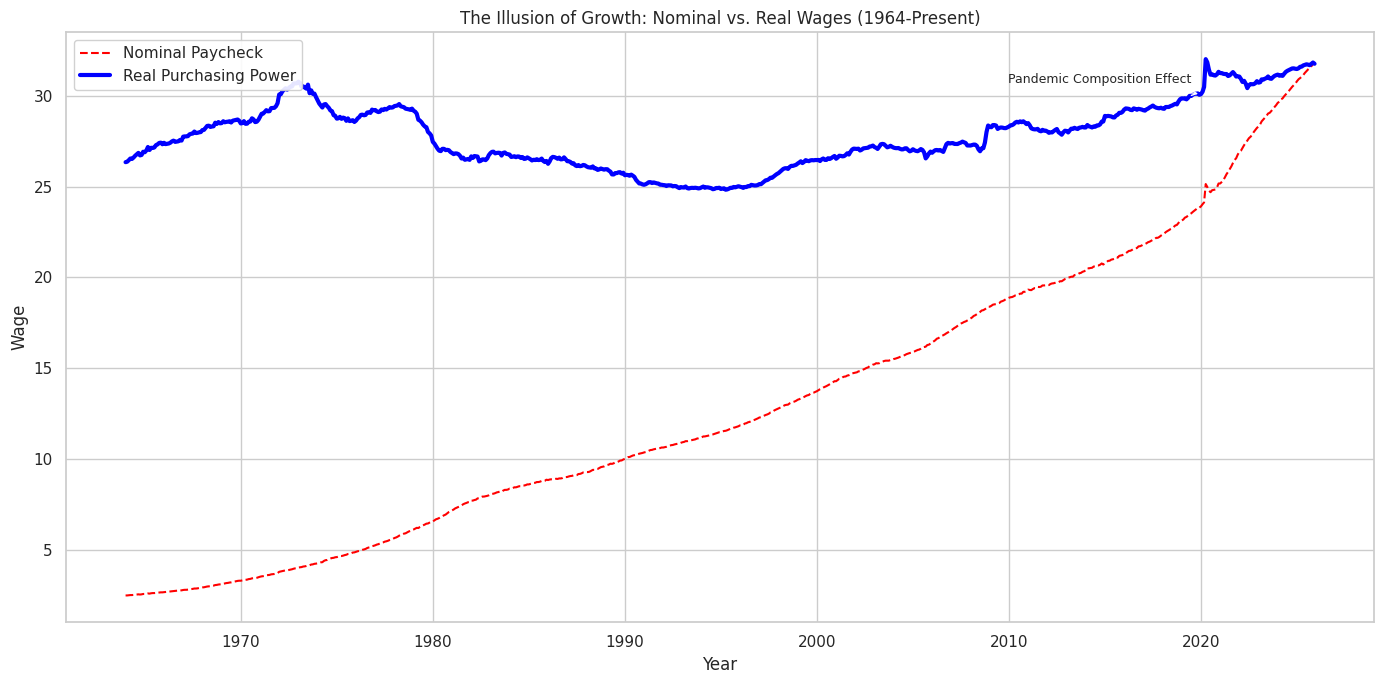

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the index is a DatetimeIndex (if not already)
# df.index = pd.to_datetime(df.index)

# Set the seaborn whitegrid theme
sns.set_theme(style="whitegrid")

# Create the figure with the specified size
plt.figure(figsize=(14, 7))

# Plot Nominal_Wage as a dashed red line
sns.lineplot(
    x=df.index,
    y=df['Nominal_wage'],
    color="red",
    linestyle="--",
    label="Nominal Paycheck",
)

# Plot Real_Wage as a thick blue line
sns.lineplot(
    x=df.index,
    y=df['Real_Wage'],
    color="blue",
    linewidth=3.0,
    label="Real Purchasing Power",
)

# Title
plt.title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)")

# Axis labels (optional but professional)
plt.xlabel("Year")
plt.ylabel("Wage")

# Annotations: locate the 2020 spike in Real_Wage and annotate with an arrow
# Find the index where Real_Wage has its maximum around 2020, or specify the exact timestamp if known.
# Here we demonstrate a robust approach: identify the 2020 datapoint and annotate near its value.

# If you know the exact 2020 point (e.g., 2020-06-01), you can set it directly:
# ts_2020 = pd.Timestamp("2020-06-01")
# But we'll search for the first 2020 entry in the index for annotation target.
try:
    # Use the first timestamp in 2020 or later
    ts_2020 = df.loc[df.index >= pd.Timestamp("2020-01-01")].index[0]
    y_2020 = df.loc[ts_2020, 'Real_Wage']
except Exception:
    # Fallback: use the maximum Real_Wage value as a proxy if 2020 isn't present
    ts_2020 = df.index[df['Real_Wage'].idxmax()]
    y_2020 = df.loc[ts_2020, 'Real_Wage']

# Annotation position (slightly to the left to avoid overlap with the line)
annot_x = ts_2020
annot_y = y_2020

plt.annotate(
    "Pandemic Composition Effect",
    xy=(annot_x, annot_y),
    xytext=(annot_x - 0.5 * pd.Timedelta(days=365), annot_y * 1.02),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
    fontsize=9,
    horizontalalignment="right",
)

# Optional grid/legend tweaks for a professional finish
plt.legend(loc="upper left", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

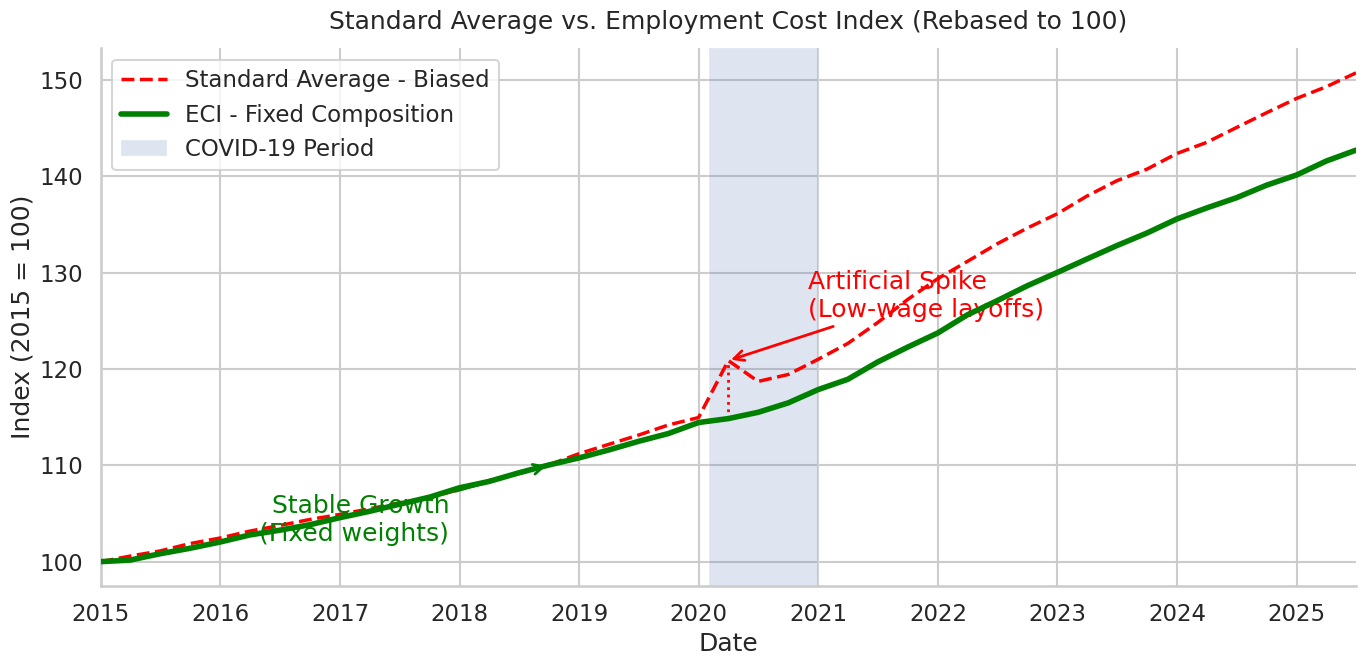

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns

# -----------------------------
# 1) Fetch ECI (fixed composition) from FRED
# -----------------------------
eci = fred.get_series("ECIWAG")
eci.index = pd.to_datetime(eci.index)
eci = eci.sort_index()

# Prep your wages Series (biased standard average)
w = wages.copy()
w.index = pd.to_datetime(w.index)
w = w.sort_index()

# -----------------------------
# 2) Filter to 2015-01-01 onwards + align on common dates
# -----------------------------
start = pd.Timestamp("2015-01-01")
w = w.loc[w.index >= start]
eci = eci.loc[eci.index >= start]

# Align to common dates (inner join handles different frequencies cleanly)
w, eci = w.align(eci, join="inner")

# -----------------------------
# 3) Rebase to 100
# -----------------------------
w_idx = (w / w.iloc[0]) * 100
eci_idx = (eci / eci.iloc[0]) * 100

# -----------------------------
# 4) Plot styling + lines
# -----------------------------
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    w_idx.index, w_idx.values,
    color="red", linestyle="--", linewidth=2.5,
    label="Standard Average - Biased", zorder=3
)
ax.plot(
    eci_idx.index, eci_idx.values,
    color="green", linestyle="-", linewidth=4.0,
    label="ECI - Fixed Composition", zorder=4
)

ax.set_title("Standard Average vs. Employment Cost Index (Rebased to 100)", pad=14)
ax.set_xlabel("Date")
ax.set_ylabel("Index (2015 = 100)")

# -----------------------------
# Add COVID-19 shaded band (like your example)
# -----------------------------
covid_start = pd.Timestamp("2020-02-01")
covid_end   = pd.Timestamp("2020-12-31")
ax.axvspan(covid_start, covid_end, alpha=0.18, zorder=1)

# Put a labeled patch into the legend for the shaded region
covid_patch = mpatches.Patch(alpha=0.18, label="COVID-19 Period")

# -----------------------------
# 5) Annotations: divergence around 2020
# -----------------------------
# Pick a spring 2020 point for the "Artificial Spike" callout
target_spike = pd.Timestamp("2020-05-01")
i_spike = w_idx.index.get_indexer([target_spike], method="nearest")[0]
x_spike = w_idx.index[i_spike]
y_w_spike = float(w_idx.iloc[i_spike])

ax.annotate(
    "Artificial Spike\n(Low-wage layoffs)",
    xy=(x_spike, y_w_spike),
    xytext=(x_spike + pd.DateOffset(months=8), y_w_spike + 4),
    color="red",
    arrowprops=dict(arrowstyle="->", lw=2, color="red"),
    ha="left", va="bottom"
)

# Add a "Stable Growth" callout along the ECI line pre-2020
target_stable = pd.Timestamp("2018-10-01")
i_stable = eci_idx.index.get_indexer([target_stable], method="nearest")[0]
x_stable = eci_idx.index[i_stable]
y_eci_stable = float(eci_idx.iloc[i_stable])

ax.annotate(
    "Stable Growth\n(Fixed weights)",
    xy=(x_stable, y_eci_stable),
    xytext=(x_stable - pd.DateOffset(months=10), y_eci_stable - 3),
    color="green",
    arrowprops=dict(arrowstyle="->", lw=2, color="green"),
    ha="right", va="top"
)

# Optional: emphasize the gap at the spike date with a vertical dotted line
y_eci_at_spike = float(eci_idx.loc[x_spike])
ax.vlines(x_spike, y_eci_at_spike, y_w_spike, colors="red", linestyles=":", linewidth=2, zorder=2)

# -----------------------------
# Axes formatting (clean year ticks like the example)
# -----------------------------
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(w_idx.index.min(), w_idx.index.max())

# Legend (include shaded patch)
handles, labels = ax.get_legend_handles_labels()
handles.append(covid_patch)
labels.append("COVID-19 Period")
ax.legend(handles, labels, loc="upper left", frameon=True)

sns.despine()
fig.tight_layout()
plt.show()

